Добрый день тем, кто это читает!

Лучший способ учиться чему-то новому - это пробовать делать это и объяснять свои действия. Поэтому я и начинаю своё изучение Python как средства анализа данных с таких игрушечных примеров.<br>
Начав эту серию материалов, я попытаюсь с помощью математико-статистического аппарата получить инсайты о балансе нежно любимых нами различных компьютерных игр. Начнём с нежного любимых HoMM III. При этом буду вспоминать подзабытые детали по анализу данных, которым учился в университете.

Если Вы вдруг хорошо знаете Python и понимаете, как оптимизировать фрагменты кода ниже - буду рад комментариям и предложениям. Впрочем, о других ошибках (<i>в коде, тексте или исходных данных, например</i>) тоже прошу сообщать ;)

Прежде чем начать, нам нужно импортировать все необходимые библиотеки.<br> 
Это делается с помощью команды import (<i>имя импортируемой библиотеки</i>) as (<i>псевдоним, по которому мы будем к этой библиотеку обращаться</i>).
Если нужно вытащить из всей библиотеки только одну функцию/процедуру, то нужна конструкция from (<i>имя библиотеки</i>) import (<i>имя функции</i>).

Для удобства восприятия я ограничиваю объём выводимых на экран данных.

In [1]:
import pandas as pd
import scipy.cluster.hierarchy
import pylab
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)

Пользуясь встроенной справкой к третьим "Героям" и материалами к прекрасному аддону Horn of the Abyss (<i>версии 1.5.0</i>), я сформировал Excel-файл, который мы и будем изучать.
Чтобы загрузить его в наш проект, нам нужна функция read_excel из библиотеки pandas, которую мы ранее импортировали под названием pd. 

Сам файлик можно забрать <a href='https://github.com/Dimidro/HoMM3_Training/blob/master/HoMM3-Units-file_2.xlsx'>здесь</a>.
Структуру таблицы можно увидеть чуть ниже.

На мой взгляд, там всё довольно элементарно, некоторых пояснений требует лишь столбцы "Колдует?" и "Защита от магии".<br>
Так как часть существ в игре накладывает эффект на цель с вероятностью 20% (например, Громовые птицы или Единороги), то для таких существ параметр "Колдует?" равен 0,2. Существа, в обычных условиях накладывающие эффект со 100%-ой вероятностью, имеют коэффициент 1 (например, Мастера Джиннов или Огры-маги). Все прочие - 0.<br>
Защита от магии. Всего в игре 59 боевых заклинаний. Из них 1 общее (<i>"Волшебная стрела"</i>), 13 из школы Воздуха, 14 - Воды, 15 - Земли, 16 - Огня. (<i>"Гром Титана" исключён</i>). 12 - 1 и 2 уровня, 15 - 3 уровня, 13 - 4 уровня и 7 заклинаний 5 уровня. Соответственно, иммунитет к каждому заклинанию даёт 1,7% к данному показателю. Если у юнита есть шанс сопротивления любому заклинанию (<i>например, гномы</i>), указываем его. Если юнит получает только часть урона от заклинаний, то делим % защиты от урона на 2. <br>
Также на всякий случай оговорюсь, что под параметром "Число целей" имеется в виду максимально возможное для данного существа число поражённых юнитов за одну атаку. Например, Чёрный Дракон атакует цель и стоящего за ней юнита, поэтому для него число целей равно 2. А вот Магог может выстрелить по цели и повредить 6 юнитов вокруг неё, поэтому для него число целей равно 1+6=7.
Гидра и Гидра Хаоса теоретически могут поразить 8 целей за счёт того, что занимают две клетки. Но так как "кармические битвы" WoG и ситуацию призыва существ я не рассматриваю, то максимум всё равно равен 7.

In [2]:
data_ish = pd.read_excel('HoMM3-Units-file_2.xlsx')
data_ish

,Раса,Юнит,Уровень,Улучш-ый?,Стоимость (зол.),Стоимость (редк. рес.),Атака,Защита,Здоровье,Мин. урон,Макс. урон,Выстрелов,Скорость,Прирост в неделю,Двойная атака?,Летает?,Безответная атака?,Число целей,Защита от магии,Колдует?
0,Замок,Копейщик,1,0,60,0,4,5,10,1,3,0,4,14.0,0,0,0,1,0.000,0.0
1,Замок,Алебардщик,1,1,75,0,6,5,10,2,3,0,5,14.0,0,0,0,1,0.000,0.0
2,Замок,Стрелок,2,0,100,0,6,3,10,2,3,12,4,9.0,0,0,0,1,0.000,0.0
3,Замок,Лучник,2,1,150,0,6,3,10,2,3,24,6,9.0,1,0,0,1,0.000,0.0
4,Замок,Грифон,3,0,200,0,8,8,25,3,6,0,6,7.0,0,1,0,1,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,Сопряжение,Элементал магмы,5,1,500,0,11,11,40,6,10,0,6,4.0,0,0,0,1,0.186,1.0
122,Сопряжение,Элементал мысли,6,0,950,0,15,13,75,10,20,0,7,2.0,0,0,1,6,1.000,0.0
123,Сопряжение,Психический элементал,6,1,1200,0,15,13,80,15,25,0,9,2.0,0,0,1,6,1.000,0.0
124,Сопряжение,Огненная птица,7,0,2000,0,18,18,150,30,40,0,15,1.3,0,1,0,2,0.000,0.0


По объекту pd.DataFrame можно получить описательную статистику (<i>число элементов, оценку математического ожидания, оценку стандартного отклонения, минимальное и максимальное значение, квартили</i>) по числовым столбцам с помощью функции Describe. С помощью такой описательной статистики можно составить представление о массиве обрабатываемых данных, пусть и весьма примерное.

In [3]:
data_ish.describe()

,Уровень,Улучш-ый?,Стоимость (зол.),Стоимость (редк. рес.),Атака,Защита,Здоровье,Мин. урон,Макс. урон,Выстрелов,Скорость,Прирост в неделю,Двойная атака?,Летает?,Безответная атака?,Число целей,Защита от магии,Колдует?
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,4.000000,0.500000,775.753968,0.166667,11.079365,10.444444,60.912698,10.531746,15.341270,3.809524,7.238095,5.703175,0.031746,0.333333,0.103175,1.380952,0.086667,0.144444
std,2.007984,0.501996,1067.829212,0.532917,5.544876,5.736278,69.305125,11.619078,15.358731,8.108972,3.186041,4.473101,0.176023,0.473286,0.305401,1.331809,0.199298,0.332399
min,1.000000,0.000000,25.000000,0.000000,2.000000,2.000000,3.000000,1.000000,2.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,0.000000,150.000000,0.000000,7.000000,6.000000,15.250000,2.000000,4.000000,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,4.000000,0.500000,350.000000,0.000000,10.000000,10.000000,32.500000,6.000000,9.000000,0.000000,7.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,6.000000,1.000000,887.500000,0.000000,15.000000,13.000000,73.750000,14.750000,20.000000,0.000000,8.750000,8.000000,0.000000,1.000000,0.000000,1.000000,0.118000,0.000000
max,7.000000,1.000000,5000.000000,3.000000,30.000000,30.000000,300.000000,50.000000,60.000000,24.000000,21.000000,20.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000


Скажем, по соотношению оценки математического ожидания и оценки стандартного отклонения можно приблизительно судить о том, насколько широк диапазон значений параметра относительно своего масштаба (<i>строго говоря, для этого в статистике используется специальная величина - коэффициент эксцесса</i>).<br>
Пользуясь такой оценкой, мы можем сказать о высоком разбросе стоимости существ и достаточно скромным разбросом по их скорости.
Сравните сами - диапазон от 25 до 5000 для стоимость существ в золоте (<i>разница в 200 раз</i>), и от 3 до 21 для скорости -  существенно меньше.<br>
Для параметров с небольшим набором доступных значений (<i>например, все столбцы правее "Прирост в неделю"</i>) такой метод, конечно, не годится.

Исследуем сбалансированность различных сторон конфликта в HoMM III с точки зрения их набора юнитов. Как это можно сделать?<br>
Один из способов - разложить похожих между собой существ по кучкам (<i>назовём их кластерами</i>), и посмотреть, сколько существ каждого вида в каждом из городов. Таким способом можно выявить и сильные/слабые стороны каждого набора юнитов.<br>
Для решения подобных задач в статистике (<i>а если быть точнее, в дисциплине "Многомерный статистический анализ"</i>) существует специальный класс методов - методы кластерного анализа.


Однако, мы не можем просто взять и скормить наши данные процедурам кластерного анализа.<br>
Требуется, чтобы значения всех параметров находились примерно в одном масштабе, иначе кластеризация будет проходить только по одному-двум из них, имеющим наибольшие абсолютные значения. В нашем случае на принадлежность к кластеру будет влиять только стоимость существ в золоте, а все остальные параметры останутся вторичными.


Поэтому мы проведём небольшое преобразование данных - вычтем из исходных значений оценку математического ожидания (<i>т.е., среднее арифметическое</i>) соответствующего параметра и поделим на оценку стандартного отклонения. Такое преобразование позволяет привести все параметры к одному масштабу (<i>очень грубо обобщая, каждое преобразованное значение имеет вероятность попадания в интервал [-3; 3], равную 99,7%</i>), при этом позволяя сохранить все различия юнитов по каждому отдельно взятому параметру. Также это позволит нам характеризовать кластера относительно "средней температуры по больнице", не зная, какие именно юниты в него входят.<br>

Полученные значения запишем в новую таблицу. Поскольку данные из первых четырёх столбцов в преобразовании не нуждаются, перенесём их неизменными. Выведем фрагмент получившейся таблицы на экран для наглядности.

In [4]:
data_pr=pd.DataFrame()
i=0
for col in data_ish.columns:
    if i>3:
        data_pr[col]=(data_ish[col]-data_ish[col].mean())/data_ish[col].std()
    else:
        data_pr[col]=data_ish[col]
    i+=1
data_pr

,Раса,Юнит,Уровень,Улучш-ый?,Стоимость (зол.),Стоимость (редк. рес.),Атака,Защита,Здоровье,Мин. урон,Макс. урон,Выстрелов,Скорость,Прирост в неделю,Двойная атака?,Летает?,Безответная атака?,Число целей,Защита от магии,Колдует?
0,Замок,Копейщик,1,0,-0.670289,-0.312744,-1.276740,-0.949125,-0.734617,-0.820353,-0.803534,-0.469791,-1.016338,1.854826,-0.180352,-0.704295,-0.337833,-0.286041,-0.434859,-0.434552
1,Замок,Алебардщик,1,1,-0.656242,-0.312744,-0.916047,-0.949125,-0.734617,-0.734288,-0.803534,-0.469791,-0.702469,1.854826,-0.180352,-0.704295,-0.337833,-0.286041,-0.434859,-0.434552
2,Замок,Стрелок,2,0,-0.632830,-0.312744,-0.916047,-1.297783,-0.734617,-0.734288,-0.803534,1.010051,-1.016338,0.737034,-0.180352,-0.704295,-0.337833,-0.286041,-0.434859,-0.434552
3,Замок,Лучник,2,1,-0.586006,-0.312744,-0.916047,-1.297783,-0.734617,-0.734288,-0.803534,2.489893,-0.388600,0.737034,5.500721,-0.704295,-0.337833,-0.286041,-0.434859,-0.434552
4,Замок,Грифон,3,0,-0.539182,-0.312744,-0.555353,-0.426138,-0.518182,-0.648222,-0.608206,-0.469791,-0.388600,0.289916,-0.180352,1.408590,-0.337833,-0.286041,-0.434859,-0.434552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,Сопряжение,Элементал магмы,5,1,-0.258238,-0.312744,-0.014313,0.096849,-0.301748,-0.390026,-0.347768,-0.469791,-0.388600,-0.380759,-0.180352,-0.704295,-0.337833,-0.286041,0.498415,2.573884
122,Сопряжение,Элементал мысли,6,0,0.163178,-0.312744,0.707073,0.445508,0.203265,-0.045765,0.303328,-0.469791,-0.074731,-0.827876,-0.180352,-0.704295,2.936549,3.468252,4.582745,-0.434552
123,Сопряжение,Психический элементал,6,1,0.397298,-0.312744,0.707073,0.445508,0.275410,0.384562,0.628876,-0.469791,0.553008,-0.827876,-0.180352,-0.704295,2.936549,3.468252,4.582745,-0.434552
124,Сопряжение,Огненная птица,7,0,1.146481,-0.312744,1.248114,1.317153,1.285436,1.675542,1.605519,-0.469791,2.436223,-0.984367,-0.180352,1.408590,-0.337833,0.464817,-0.434859,-0.434552


Если значение параметра в таблице ниже нуля, то оно ниже, чем "среднее по больнице".

Как видим в табличке ниже, после преобразований оценка математического ожидания для параметров существ равна нулю (<i>из-за погрешностей машинного округления оно отображается как число с минимум 15 нулями после запятой, с припиской вида e-15</i>), а среднее квадратическое отклонение равно 1.

In [5]:
data_pr.describe()

,Уровень,Улучш-ый?,Стоимость (зол.),Стоимость (редк. рес.),Атака,Защита,Здоровье,Мин. урон,Макс. урон,Выстрелов,Скорость,Прирост в неделю,Двойная атака?,Летает?,Безответная атака?,Число целей,Защита от магии,Колдует?
count,126.000000,126.000000,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02,1.260000e+02
mean,4.000000,0.500000,-5.639228e-17,7.753939e-17,4.934325e-17,-2.819614e-17,3.524518e-17,-7.049035e-18,-4.229421e-17,-1.321694e-17,-7.049035e-18,1.480297e-16,1.449458e-16,-5.286776e-17,2.255691e-16,-3.172066e-17,5.374889e-17,-1.339317e-16
std,2.007984,0.501996,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000000,0.000000,-7.030656e-01,-3.127444e-01,-1.637433e+00,-1.472112e+00,-8.356193e-01,-8.203530e-01,-8.686440e-01,-4.697912e-01,-1.330207e+00,-1.051435e+00,-1.803515e-01,-7.042952e-01,-3.378331e-01,-2.860414e-01,-4.348591e-01,-4.345518e-01
25%,2.000000,0.000000,-5.860057e-01,-3.127444e-01,-7.357000e-01,-7.747958e-01,-6.588647e-01,-7.342877e-01,-7.384250e-01,-4.697912e-01,-7.024691e-01,-8.278764e-01,-1.803515e-01,-7.042952e-01,-3.378331e-01,-2.860414e-01,-4.348591e-01,-4.345518e-01
50%,4.000000,0.500000,-3.987098e-01,-3.127444e-01,-1.946599e-01,-7.747958e-02,-4.099653e-01,-3.900263e-01,-4.128772e-01,-4.697912e-01,-7.473075e-02,-3.807593e-01,-1.803515e-01,-7.042952e-01,-3.378331e-01,-2.860414e-01,-4.348591e-01,-4.345518e-01
75%,6.000000,1.000000,1.046479e-01,-3.127444e-01,7.070735e-01,4.455076e-01,1.852287e-01,3.630455e-01,3.033278e-01,-4.697912e-01,4.745403e-01,5.134750e-01,-1.803515e-01,1.408590e+00,-3.378331e-01,-2.860414e-01,1.572183e-01,-4.345518e-01
max,7.000000,1.000000,3.955919e+00,5.316655e+00,3.412274e+00,3.409102e+00,3.449778e+00,3.396849e+00,2.907710e+00,2.489893e+00,4.319437e+00,3.196178e+00,5.500721e+00,1.408590e+00,2.936549e+00,4.219110e+00,4.582745e+00,2.573884e+00


Для того, чтобы в дальнейшем нам было удобно анализировать данные, разобьём их на две части - названия юнитов и собственно массив, который будем прогонять через процедуры кластерного анализа.

In [6]:
data_for_clust=data_pr.loc[0:,'Стоимость (зол.)':'Колдует?']
data_names=data_pr.loc[0:,'Раса':'Улучш-ый?']
data_names

,Раса,Юнит,Уровень,Улучш-ый?
0,Замок,Копейщик,1,0
1,Замок,Алебардщик,1,1
2,Замок,Стрелок,2,0
3,Замок,Лучник,2,1
4,Замок,Грифон,3,0
...,...,...,...,...
121,Сопряжение,Элементал магмы,5,1
122,Сопряжение,Элементал мысли,6,0
123,Сопряжение,Психический элементал,6,1
124,Сопряжение,Огненная птица,7,0


<font size="1"><i>Буду благодарен за подсказку, как заставить Jupyter Notebook внутри тэга "table" применять явным образом указанные параметры border, bordercolor, align и т.п. При экспорте в html всё нормально.</i></font>

Методы кластеризации можно поделить на две группы - иерархические и итерационные. Их назначение одинаково - объединение похожих объектов в кластера, но различий между ними очень много.

<table border="1" bordercolor="black" align="left" valign="top">
<tr align="center">
<td><b>Параметр</b></td>
<td><b>Иерархические методы</b></td>
<td><b>Итерационные методы</b></td>
</tr>
<tr>
<td>Число кластеров</td>
<td>Заранее неизвестно, подлежит определению</td>
<td>Зависит от метода <br>(<i>k-средних/k-медиан - известно заранее; <br>методы "форели" и "взаимного поглощения" - <br>определяется в процессе анализа</i>)</td>
</tr>
<tr>
<td>От чего зависит<br> результат</td>
<td>Метод, метрика</td>
<td>Метод, метрика, выбор начальных параметров <br> (<i>зависят от метода</i>)</td>
</tr>
<tr>
<td>Графическое<br> представление</td>
<td>Дендрограмма ("дерево")</td>
<td>k групп точек в m-мерном пространстве,<br> где m - число параметров,<br> по которым проводится кластеризация</td>
</tr>
<tr>
<td>Исходное <br>предположение</td>
<td>Каждый объект является отдельным кластером<br> (<i>агломеративные методы класт.анализа</i>)<br><br> Все объекты изначально объединены в один кластер<br> (<i>дивизимные методы класт.анализа</i>)</td>
<td>Зависит от метода: <br><br>k-средних - определённым методом отбираются k точек, <br>которые считаются исходными центрами кластеров,<br> где k - число кластеров.<br><br>"Форель" - исходный радиус m-мерной гиперсферы <br><br>и т.п.</td>
</tr>
<tr>
<td>Желательное число <br>кластеризуемых объектов</td>
<td>Не более 50 <br>(<i>большее число объектов <br>сложно адекватно визуализировать</i>)</td>
<td>Не менее числа кластеров <br>(<i>если в методе их количество известно заранее</i>)</td>
</tr>
</table>

Рассматривать будем иерархический агломеративный метод и итерационный метод k-средних.<br>
Начнём c иерархических методов.


Так как объектов у нас существенно больше (<i>126 vs 50</i>) чем рекомендуется при использовании иерархических методов кластеризации, то для терпимого визуального отображения придётся внести пару твиков в стандартные параметры модуля отрисовки графиков. Этим занимаются первые три строчки кода:<br>1) выбираем более приятный глазу шрифт;
<br> 2) уменьшаем размер шрифта на подписях осей и точек данных;
<br> 3) уменьшаем толщину линий дендрограммы, чтобы они не сливались друг с другом.

Первый этап иерархической кластеризации: строим матрицу расстояний между юнитами на основе ранее выделенного массива data_for_clust. Так как все данные у нас центрированы и нормированы, то старая-добрая евклидова метрика нам поможет. Она является метрикой по умолчанию. В нашем случае получим матрицу 126 строк на 126 столбцов, в которой на пересечении i-той строки и j-того столбца будет расстоянием между i-тым и j-тым юнитом.


Второй этап - по полученной матрице расстояний строим массив данных для дендрограммы. Существует несколько основных правил объединения объектов в кластера: одиночных связей, полных связей и т.п. Я предпочитаю использовать метод Уорда, несмотря на наличие в нём дополнительных вычислений. При его использовании, как правило, легче всего дать содержательное объяснение полученным кластерам. Ещё один его плюс - объекты распределяются по кластерам более равномерно, чем при других методах.


Третий этап - собственно построение дендрограммы. Для удобства восприятия с помощью дополнительных параметров я упорядочиваю на графике кластера по числу объектов, а сами объекты располагаю в порядке роста расстояния между ними. Так как объектов слишком много для иерархического метода, то что-то рассмотреть можно только в высоком разрешении и при "повороте" дендрограммы.<br>
<a href="https://raw.githubusercontent.com/Dimidro/HoMM3_Training/master/hier_HoMM_clust_v2.png" target="_parent">Посмотреть дендрограмму полностью</a>

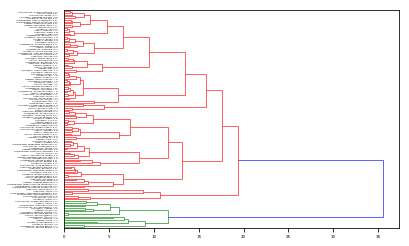

In [7]:
plt.rcParams['font.family']='Verdana'
plt.rcParams['font.size']=4
plt.rcParams['lines.linewidth']=0.6
Y = pdist(data_for_clust) 
Z = scipy.cluster.hierarchy.linkage(Y, method='ward')
scipy.cluster.hierarchy.dendrogram(Z, orientation='right', count_sort=True, distance_sort=True, labels=np.array(data_names), leaf_font_size = 2)
plt.savefig('hier_HoMM_clust_v2.png', format='png', dpi=360)
plt.show()

In [8]:
Z

array([[  43.        ,   85.        ,    0.25141885,    2.        ],
       [   1.        ,   71.        ,    0.28463585,    2.        ],
       [   2.        ,   44.        ,    0.29500878,    2.        ],
       [  30.        ,   72.        ,    0.30471024,    2.        ],
       [  80.        ,  108.        ,    0.32075613,    2.        ],
       [  48.        ,   49.        ,    0.32259806,    2.        ],
       [  50.        ,   78.        ,    0.33716603,    2.        ],
       [  22.        ,   23.        ,    0.35251438,    2.        ],
       [   0.        ,   70.        ,    0.36623901,    2.        ],
       [  42.        ,   84.        ,    0.40098157,    2.        ],
       [  98.        ,   99.        ,    0.40221908,    2.        ],
       [  26.        ,   82.        ,    0.41255221,    2.        ],
       [  18.        ,   89.        ,    0.41846842,    2.        ],
       [  36.        ,   92.        ,    0.42691225,    2.        ],
       [   9.        ,   35.      

Построив дендрограмму, мы можем примерно оценить количество кластеров, на которое лучше разбить совокупность.<br>
Одним из подходов можно считать выбор такого числа кластеров, при котором происходит объединяются наиболее далекие друг от друга кластера (<i>разница расстояний между кластерами при текущем объединении и прошлом объединениях</i>). Предположим, что число кластеров не может быть менее 7 (<i>по количеству уровней существ</i>). Для наглядности построим график. Так как мы покажем на графике только его небольшой, значимый для нас кусочек, то можно и увеличить шрифт.

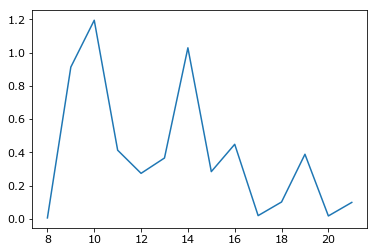

In [9]:
plt.rcParams['font.size']=11
plt.rcParams['lines.linewidth']=1.5
dist=list()
for mass in Z:
    dist.append(mass[2])
dist_ch=list()
clust_count=list()
for i in range (105,119):
    dist_ch.append((dist[i]-dist[i-1]))
    clust_count.append(125-i+1)
plt.plot(clust_count, dist_ch)
plt.show()

Из графика видно, что хорошими вариантами будут 10 и 14 кластеров. Остановимся на втором варианте, благо число признаков у нас довольно велико (<i>16</i>) и есть основания предполагать, что совокупность юнита весьма разнородна.


Построим искомые кластера с помощью метода k-средних.<br>
У каждого набора данных в процессе кластеризации могут выявиться свои особенности.<br>
Например, если я использую определение начальных точек по умолчанию (<i>параметр minit</i>), то у меня с большой долей вероятности могут получиться один или даже несколько пустых кластеров. Дело в том, что наш набор данных не подчиняется нормальному закону распределения, и при большом числе кластеров (<i>а 14 - это довольно много</i>) генерация начальных центров по умолчанию (<i>с использованием нормального закона распределения</i>) может создать несколько точек, которые находятся слишком далеко от нашего набора данных и, следовательно, соответствующие им кластера останутся пустыми в течение всех итераций.<br>
Поэтому в данном случае уместнее использовать метод "points", который в качестве стартовых центров кластеров выбирает объекты в исходной совокупности.<br>
Стандартный алгоритм кластеризации мне не нравится, потому что тут нельзя выбрать стартовые центры кластеров исходя из критерия <b>максимизации</b> суммы расстояний между ними. Так убивались бы сразу два зайца - стабилизировались результаты процедуры и получались более чёткие границы между кластерами. Если кто знает функцию кластеризации методом k-средних с учётом этого критерия - поделитесь, пожалуйста. Самому писать лениво ^_^. 
<font size=1>Результаты стандартной процедуры, к тому же, ОЧЕНЬ СИЛЬНО зависят от СЛУЧАЙНОГО выбора стартовых точек, что не позволяет сделать их воспроизводимыми даже в рамках одной и той же сессии на одной и том же компьютере. Установка параметра random.seed не помогает.</font>


Стандартная процедура scipy.cluster.vq.kmeans2 выдаёт два массива:<br>
Массив 1 содержит в себе количество подмассивов, равное заданному числу кластеров, каждый из которых содержит в себе координаты центров соответствующего кластера.<br>
Массив 2 содержит в себе количество чисел, равное количеству объектов в совокупности. Значение i-того числа равно кластеру, к которому принадлежит i-тый объект.

In [10]:
clustered=scipy.cluster.vq.kmeans2(data_for_clust, 14, minit='points')

Сопоставим юнитов с кластерами, результат затем выведем на экран. Детально по каждому кластеру и вошедшим в него юнитам пройдёмся ниже.

In [11]:
i=0
units=list()
vsp=list()
for unit in clustered[1]:
    vsp=[unit, data_names.loc[i,'Раса'], data_names.loc[i,'Юнит'], data_names.loc[i,'Уровень'], data_names.loc[i,'Улучш-ый?']]
    units.append(vsp)
    i+=1
units

[[7, 'Замок', 'Копейщик', 1, 0],
 [7, 'Замок', 'Алебардщик', 1, 1],
 [5, 'Замок', 'Стрелок', 2, 0],
 [4, 'Замок', 'Лучник', 2, 1],
 [8, 'Замок', 'Грифон', 3, 0],
 [8, 'Замок', 'Королевский грифон', 3, 1],
 [11, 'Замок', 'Мечник', 4, 0],
 [11, 'Замок', 'Крестоносец', 4, 1],
 [11, 'Замок', 'Монах', 5, 0],
 [4, 'Замок', 'Фанатик', 5, 1],
 [3, 'Замок', 'Всадник', 6, 0],
 [3, 'Замок', 'Чемпион', 6, 1],
 [1, 'Замок', 'Ангел', 7, 0],
 [2, 'Замок', 'Архангел', 7, 1],
 [7, 'Оплот', 'Кентавр', 1, 0],
 [7, 'Оплот', 'Капитан кентавров', 1, 1],
 [5, 'Оплот', 'Гном', 2, 0],
 [5, 'Оплот', 'Боевой гном', 2, 1],
 [4, 'Оплот', 'Лесной эльф', 3, 0],
 [4, 'Оплот', 'Высокий эльф', 3, 1],
 [8, 'Оплот', 'Пегас', 4, 0],
 [8, 'Оплот', 'Серебряный пегас', 4, 1],
 [9, 'Оплот', 'Дендроид-страж', 5, 0],
 [9, 'Оплот', 'Дендроид-воин', 5, 1],
 [3, 'Оплот', 'Единорог', 6, 0],
 [3, 'Оплот', 'Боевой единорог', 6, 1],
 [1, 'Оплот', 'Зеленый дракон', 7, 0],
 [2, 'Оплот', 'Золотой дракон', 7, 1],
 [7, 'Башня', 'Гремлин', 

Сохраним результаты кластеризации в отдельном списке.<br>
Чтобы в дальнейшем список юнитов по каждому кластеру отобразился полностью, изменим максимальное значение выводимых на экране строк.

In [12]:
pd.set_option('display.max_rows', 40)
clustered_float=list([])
for elem in clustered[0]:
    clustered_float.append(elem)
units_cols=list([])
units_cols.append('Кластер')
for col in data_names.columns:
    units_cols.append(col)
exported_clusters=pd.DataFrame(clustered_float, columns=data_for_clust.columns)
clustered_units=pd.DataFrame(units, columns=units_cols)
exported_clusters

,Стоимость (зол.),Стоимость (редк. рес.),Атака,Защита,Здоровье,Мин. урон,Макс. урон,Выстрелов,Скорость,Прирост в неделю,Двойная атака?,Летает?,Безответная атака?,Число целей,Защита от магии,Колдует?
0,-0.359378,-0.312744,-0.230729,-0.112345,-0.431609,-0.458879,-0.477987,-0.469791,0.866877,-0.023066,-0.180352,1.408590e+00,0.317043,-0.286041,0.040810,2.573884
1,1.479452,0.938233,1.328268,1.259043,1.798465,2.058055,2.256614,-0.469791,0.971500,-1.043983,-0.180352,7.042952e-01,-0.337833,-0.035755,0.471655,-0.367698
2,3.253560,3.752933,2.600714,2.595566,2.728331,2.392753,2.148098,0.023490,2.854715,-1.040257,-0.180352,1.056443e+00,0.207897,0.089388,1.195026,0.568260
3,0.082406,-0.312744,0.634935,0.584971,0.250159,0.354439,0.371693,-0.371135,0.286219,-0.749631,-0.180352,2.465033e-01,-0.337833,-0.286041,-0.139322,-0.223961
4,-0.378179,-0.312744,-0.236278,-0.439548,-0.507083,-0.383406,-0.447936,2.376059,-0.292025,-0.019626,0.693660,-7.042952e-01,-0.337833,0.753609,-0.343770,-0.434552
5,-0.620789,-0.312744,-0.941810,-0.899317,-0.690299,-0.740435,-0.766329,0.058724,-0.926661,0.784939,-0.180352,-7.042952e-01,-0.337833,-0.286041,-0.050654,-0.391574
6,1.111363,0.156372,0.887420,0.968495,1.213291,0.707307,1.198584,-0.469791,-0.074731,-0.939656,-0.180352,-7.042952e-01,2.936549,3.843681,2.073943,-0.434552
7,-0.677312,-0.312744,-1.276740,-1.247975,-0.795424,-0.801910,-0.836089,-0.399323,-0.455858,2.174196,-0.180352,-4.024544e-01,-0.103949,-0.286041,-0.422673,-0.434552
8,-0.512760,-0.312744,-0.542471,-0.488398,-0.548071,-0.654370,-0.622158,-0.469791,0.059785,0.194106,-0.180352,1.257670e+00,0.363820,-0.178776,-0.125560,-0.434552
9,-0.383102,-0.312744,-0.254775,0.213069,-0.133411,-0.160519,-0.174142,-0.469791,-1.016338,-0.529798,-0.180352,-7.042952e-01,-0.337833,-0.286041,-0.434859,2.573884


На этом этапе уже можно характеризовать кластера. Но для того, чтобы понимать средние значения исходных параметров для центров кластеров, проведём операцию, обратную центрированию и нормированию. Благо исходную совокупность мы никуда не девали и для неё по-прежнему доступны оценки математического ожидания и среднеквадратического отклонения.

In [13]:
clust_pr=pd.DataFrame()
i=0
for col in exported_clusters.columns:
    clust_pr[col]=(exported_clusters[col]*data_ish[col].std()+data_ish[col].mean())
    i+=1
clust_pr

,Стоимость (зол.),Стоимость (редк. рес.),Атака,Защита,Здоровье,Мин. урон,Макс. урон,Выстрелов,Скорость,Прирост в неделю,Двойная атака?,Летает?,Безответная атака?,Число целей,Защита от магии,Колдует?
0,392.000000,0.000000e+00,9.800000,9.800000,31.000000,5.200000,8.000000,0.000000e+00,10.000000,5.600000,0.000000e+00,1.000000e+00,0.200000,1.000000,0.094800,1.000000e+00
1,2355.555556,6.666667e-01,18.444444,17.666667,185.555556,34.444444,50.000000,4.440892e-16,10.333333,1.033333,0.000000e+00,6.666667e-01,0.000000,1.333333,0.180667,2.222222e-02
2,4250.000000,2.166667e+00,25.500000,25.333333,250.000000,38.333333,48.333333,4.000000e+00,16.333333,1.050000,0.000000e+00,8.333333e-01,0.166667,1.500000,0.324833,3.333333e-01
3,863.750000,5.551115e-17,14.600000,13.800000,78.250000,14.650000,21.050000,8.000000e-01,8.150000,2.350000,1.387779e-17,4.500000e-01,0.000000,1.000000,0.058900,7.000000e-02
4,371.923077,0.000000e+00,9.769231,7.923077,25.769231,6.076923,8.461538,2.307692e+01,6.307692,5.615385,1.538462e-01,-1.110223e-16,0.000000,2.384615,0.018154,2.775558e-17
5,112.857143,0.000000e+00,5.857143,5.285714,13.071429,1.928571,3.571429,4.285714e+00,4.285714,9.214286,6.938894e-18,-1.110223e-16,0.000000,1.000000,0.076571,1.428571e-02
6,1962.500000,2.500000e-01,16.000000,16.000000,145.000000,18.750000,33.750000,0.000000e+00,7.000000,1.500000,0.000000e+00,0.000000e+00,1.000000,6.500000,0.500000,0.000000e+00
7,52.500000,0.000000e+00,4.000000,3.285714,5.785714,1.214286,2.500000,5.714286e-01,5.785714,15.428571,6.938894e-18,1.428571e-01,0.071429,1.000000,0.002429,2.775558e-17
8,228.214286,0.000000e+00,8.071429,7.642857,22.928571,2.928571,5.785714,-4.440892e-16,7.428571,6.571429,6.938894e-18,9.285714e-01,0.214286,1.142857,0.061643,2.775558e-17
9,366.666667,0.000000e+00,9.666667,11.666667,51.666667,8.666667,12.666667,-4.440892e-16,4.000000,3.333333,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,1.000000e+00


Попробуем охарактеризовать получившиеся кластера, а затем проверим наши выводы, просмотрев списки существ по кластерам<br><br>

Кластер 0 - относительно недорогие существа с приростом чуть выше среднего, страдающие от дефицита Здоровья и Скорости и имеющие довольно низкий Урон. Некоторые из них могут накладывать эффекты на союзников/противников. Сюда по всему, в этом кластере находятся существа 2-3 уровней, которые должны своей грудью закрывать стрелков, либо сами являющиеся стрелками. В целом - это один из наихудших кластеров. Назовём этот кластер <b>"Вспомогательные отряды"</b>.<br><br>

Кластер 1 - казалось бы, слабые по всем характеристикам существа, не меньше половины из которых стреляет. Но у них есть одно очень важное достоинство - они атакуют дважды. Поэтому характеристики "урон" от них "в уме" можно умножать на коэффициент от 1.5 до 2 (<i>в зависимости от того, сколько существ останется в живых после контратаки</i>). Назовём этот кластер <b>"Двойная атака"</b>.<br><br>

Кластер 2 - довольно дешёвые существа со средними Атакой, Защитой и скоростью, более трети из которых летает. Но все из них способны накладывать заклинания на союзников или противников. Из недостатков - юниты этого кластера имеют сравнительно небольшой урон, а их небольшой прирост вынуждает беречь таких существ на поле боя. Назовём этот кластер <b>"Боевые маги"</b>.<br><br>

Кластер 3 - недорогие, но слабые по всем характеристикам, кроме Скорости, существа. Однако, все из них способны летать, а некоторые - даже накладывать заклинания на противников и союзников. Скорее всего, их следует использовать исключительно для блокирования вражеских стрелков. Боя с остальными существами им лучше избегать. Назовём этот кластер <b>"Дешёвые летуны"</b>.<br><br>

Кластер 4 - эти существа средние по всем параметрам (<i>включая стоимость</i>). Все из них атакуют по площади. При этом около половины из них стреляет. Поэтому юниты из этого кластера крайне опасны в умелых руках. У них довольно низкий прирост, поэтому таких товарищей на поле боя следует беречь. Назовём этот кластер <b>"AoE-урон"</b> (<i>Area of Effect</i>).<br><br>

Кластер 5 - стоимость выше среднего, все остальные параметры на высоком уровне. Судя по приросту, существа из этого кластера - 6 уровня. Назовём этот кластер <b>"Tier 6"</b>.<br><br>

Кластер 6 - Быстро. Внушительно. Дорого. Судя по приросту, кластер состоит из существ исключительно 7ого уровня. Назовём этот кластер <b>"Элита"</b>.<br><br>

Кластер 7 - довольно слабые существа, но стреляют. Судя по приросту, здесь находятся существа 2-3 уровней. Назовём этот кластер <b>"Базовые стрелки"</b>.<br><br>

Кластер 8 - стоимость ниже среднего, внушительная Атака с неплохим Уроном при дефиците Защиты и Здоровья. Все эти существа стреляют, но нуждаются в надёжном прикрытии. Назовём этот кластер <b>"Продвинутые стрелки"</b>.<br><br>

Кластер 9 - судя по приросту, в этот кластер попали существа 7ого уровня. При этом все они обладают безответной атакой, а большая часть из них бьёт по площади. Похоже, что сюда попал кто-то из Дьяволов и обе Гидры. При лобовом сравнении характеристик они слабее, чем существа из  кластера 6, но в правильных руках способны добавить противнику седых волос. Назовём этот кластер <b>"Большие и страшные"</b>.<br><br>

Кластер 10 - юниты из этого кластера слабы по всем боевым параметрам, и можно было бы сказать, что они не стоят своих денег. Однако высокая скорость, большой прирост, безответная атака и то, что большинство из них летает, не дают этого сделать. Назовём этот кластер <b>"Борзые малявки"</b>.<br><br>

Кластер 11 - самая низкая стоимость и отвратительные характеристики, включая скорость. Единственное, с чем у них хорошо - с приростом. Обычное <b>"Пушечное мясо"</b>.

In [14]:
clustered_units.loc[clustered_units.Кластер==0]

,Кластер,Раса,Юнит,Уровень,Улучш-ый?
37,0,Башня,Владыка джиннов,5,1
63,0,Некрополис,Лорд вампиров,4,1
102,0,Крепость,Змий,3,0
103,0,Крепость,Стрекоза,3,1
119,0,Сопряжение,Энергетический элементал,4,1


Кластер 0 - <b>"Вспомогательные отряды"</b>.<br>
Исходные предположения верны. Разве что немного промахнулись с диапазоном уровней - имеем 4 существа 5 уровня и 6 существ 4 уровня.

In [15]:
clustered_units.loc[clustered_units.Кластер==1]

,Кластер,Раса,Юнит,Уровень,Улучш-ый?
12,1,Замок,Ангел,7,0
26,1,Оплот,Зеленый дракон,7,0
40,1,Башня,Гигант,7,0
68,1,Некрополис,Костяной дракон,7,0
69,1,Некрополис,Призрачный дракон,7,1
82,1,Подземелье,Красный дракон,7,0
96,1,Цитадель,Чудище,7,0
97,1,Цитадель,Древнее чудище,7,1
124,1,Сопряжение,Огненная птица,7,0


Кластер 1 - <b>"Двойная атака"</b>.<br> Исходные предположения верны.

In [16]:
clustered_units.loc[clustered_units.Кластер==2]

,Кластер,Раса,Юнит,Уровень,Улучш-ый?
13,2,Замок,Архангел,7,1
27,2,Оплот,Золотой дракон,7,1
41,2,Башня,Титан,7,1
55,2,Инферно,Архидьявол,7,1
83,2,Подземелье,Черный дракон,7,1
125,2,Сопряжение,Феникс,7,1


Кластер 2 - <b>"Боевые маги"</b>.<br> Исходные предположения верны. Разве что Змии/Стрекозы с точки зрения боевых характеристик заметно слабее остальных юнитов кластера и существенно превосходят их по Скорости.

In [17]:
clustered_units.loc[clustered_units.Кластер==3]

,Кластер,Раса,Юнит,Уровень,Улучш-ый?
10,3,Замок,Всадник,6,0
11,3,Замок,Чемпион,6,1
24,3,Оплот,Единорог,6,0
25,3,Оплот,Боевой единорог,6,1
36,3,Башня,Джинн,5,0
50,3,Инферно,Адское отродье,5,0
52,3,Инферно,Ифрит,6,0
53,3,Инферно,Султан ифритов,6,1
66,3,Некрополис,Черный рыцарь,6,0
67,3,Некрополис,Рыцарь смерти,6,1


Кластер 3 - <b>"Дешёвые летуны"</b>. <br>Сложно назвать Джиннов, Рухов и Громовых птиц дешёвыми юнитами. В остальном исходные предположения верны.

In [18]:
clustered_units.loc[clustered_units.Кластер==4]

,Кластер,Раса,Юнит,Уровень,Улучш-ый?
3,4,Замок,Лучник,2,1
9,4,Замок,Фанатик,5,1
18,4,Оплот,Лесной эльф,3,0
19,4,Оплот,Высокий эльф,3,1
34,4,Башня,Маг,4,0
35,4,Башня,Архимаг,4,1
45,4,Инферно,Магог,2,1
64,4,Некрополис,Лич,5,0
65,4,Некрополис,Могучий лич,5,1
75,4,Подземелье,Злобоглаз,3,1


Кластер 4 - <b>"AoE-урон"</b>. <br>Так как по 6-7 юнитов за одну атаку могут атаковать крайне немногие юниты в игре (<i>в этом списке не хватает только Гидр</i>), то влияние признака "Число целей" на результаты классификации крайне велико. Будь магоги более сильным и дорогим юнитом или не обладай они атакой по площади - в этот кластер могли бы попасть и Гидры.

In [19]:
clustered_units.loc[clustered_units.Кластер==5]

,Кластер,Раса,Юнит,Уровень,Улучш-ый?
2,5,Замок,Стрелок,2,0
16,5,Оплот,Гном,2,0
17,5,Оплот,Боевой гном,2,1
44,5,Инферно,Гог,2,0
56,5,Некрополис,Скелет,1,0
57,5,Некрополис,Скелет-воин,1,1
58,5,Некрополис,Ходячий мертвец,2,0
59,5,Некрополис,Зомби,2,1
74,5,Подземелье,Бехолдер,3,0
86,5,Цитадель,Наездник на волке,2,0


Кластер 5 - <b>"Tier 6"</b>.<br>
В целом наши предположения верны. Имеем двух сильнейших существ пятого уровня (<i>Царь Минотавров и Улучшенная Горгона</i>) и трёх слабейших существ седьмого уровня (<i>Костяной дракон, Чудище, Огненная птица</i>). 

In [20]:
clustered_units.loc[clustered_units.Кластер==6]

,Кластер,Раса,Юнит,Уровень,Улучш-ый?
110,6,Крепость,Гидра,7,0
111,6,Крепость,Гидра хаоса,7,1
122,6,Сопряжение,Элементал мысли,6,0
123,6,Сопряжение,Психический элементал,6,1


Кластер 6 - <b>"Элита"</b>.<br>
Исходные предположения верны.

In [21]:
clustered_units.loc[clustered_units.Кластер==7]

,Кластер,Раса,Юнит,Уровень,Улучш-ый?
0,7,Замок,Копейщик,1,0
1,7,Замок,Алебардщик,1,1
14,7,Оплот,Кентавр,1,0
15,7,Оплот,Капитан кентавров,1,1
28,7,Башня,Гремлин,1,0
29,7,Башня,Мастер-гремлин,1,1
42,7,Инферно,Бес,1,0
43,7,Инферно,Черт,1,1
70,7,Подземелье,Троглодит,1,0
71,7,Подземелье,Адский троглодит,1,1


Кластер 7 - <b>"Базовые стрелки"</b>.<br>
Исходные предположения верны. Обратите внимание: Лесной эльф - единственное неулучшенное существо здесь.

In [22]:
clustered_units.loc[clustered_units.Кластер==8]

,Кластер,Раса,Юнит,Уровень,Улучш-ый?
4,8,Замок,Грифон,3,0
5,8,Замок,Королевский грифон,3,1
20,8,Оплот,Пегас,4,0
21,8,Оплот,Серебряный пегас,4,1
30,8,Башня,Каменная горгулья,2,0
31,8,Башня,Обсидиановая горгулья,2,1
47,8,Инферно,Цербер,3,1
60,8,Некрополис,Дух,3,0
61,8,Некрополис,Привидение,3,1
62,8,Некрополис,Вампир,4,0


Кластер 8 - <b>"Продвинутые стрелки"</b>.<br>
Исходные предположения верны.

In [23]:
clustered_units.loc[clustered_units.Кластер==9]

,Кластер,Раса,Юнит,Уровень,Улучш-ый?
22,9,Оплот,Дендроид-страж,5,0
23,9,Оплот,Дендроид-воин,5,1
104,9,Крепость,Василиск,4,0


Кластер 9 - <b>"Большие и страшные"</b>.<br>
Исходные предположения верны.

In [24]:
clustered_units.loc[clustered_units.Кластер==10]

,Кластер,Раса,Юнит,Уровень,Улучш-ый?
38,10,Башня,Нага,6,0
39,10,Башня,Королева наг,6,1
54,10,Инферно,Дьявол,7,0


In [25]:
clustered_units.loc[clustered_units.Кластер==11]

,Кластер,Раса,Юнит,Уровень,Улучш-ый?
6,11,Замок,Мечник,4,0
7,11,Замок,Крестоносец,4,1
8,11,Замок,Монах,5,0
32,11,Башня,Каменный голем,3,0
33,11,Башня,Железный голем,3,1
46,11,Инферно,Гончая ада,3,0
48,11,Инферно,Демон,4,0
49,11,Инферно,Рогатый демон,4,1
76,11,Подземелье,Медуза,4,0
77,11,Подземелье,Королева медуз,4,1


In [26]:
clustered_units.loc[clustered_units.Кластер==12]

,Кластер,Раса,Юнит,Уровень,Улучш-ый?
115,12,Сопряжение,Штормовой элементал,2,1
117,12,Сопряжение,Ледяной элементал,3,1


In [27]:
clustered_units.loc[clustered_units.Кластер==13]

,Кластер,Раса,Юнит,Уровень,Улучш-ый?
51,13,Инферно,Владыка бездны,5,1
91,13,Цитадель,Огр-маг,4,1
105,13,Крепость,Великий василиск,4,1
121,13,Сопряжение,Элементал магмы,5,1


Как и в Excel, в Python, мы можем построить сводную таблицу.<br>
Подсчитаем, сколько существ из каждого кластера есть в каждом из городов. Это поможет нам понять, юнитов какого типа не хватает тому или иному городу в игре, а также оценить сбалансированность набора юнитов. Если юнитов данного кластера в выбранном городе нет - ставим 0.<br>
Для того, чтобы сделать более правильные выводы, отдельно отобразим статистику по улучшенным и неулучшенным линейкам юнитов.

In [28]:
pd.pivot_table(clustered_units, index=['Раса', 'Улучш-ый?'], values='Юнит', columns=['Кластер'], aggfunc='count', fill_value=0)

Кластер               0   1   2   3   4   5   6   7   8   9   10  11  12  13
Раса       Улучш-ый?                                                        
Башня      0           0   1   0   1   1   0   0   1   1   0   1   1   0   0
           1           1   0   1   0   1   0   0   1   1   0   1   1   0   0
Замок      0           0   1   0   1   0   1   0   1   1   0   0   2   0   0
           1           0   0   1   1   2   0   0   1   1   0   0   1   0   0
Инферно    0           0   0   0   2   0   1   0   1   0   0   1   2   0   0
           1           0   0   1   1   1   0   0   1   1   0   0   1   0   1
Крепость   0           1   0   0   1   0   2   1   0   0   1   0   1   0   0
           1           1   0   0   2   1   1   1   0   0   0   0   0   0   1
Некрополис 0           0   1   0   1   1   2   0   0   2   0   0   0   0   0
           1           1   1   0   1   1   2   0   0   1   0   0   0   0   0
Оплот      0           0   1   0   1   1   1   0   1   1   1   0   0   0   0
           1           0   0   1   1   1   1   0   1   1   1   0   0   0   0
Подземелье 0           0   1   0   2   0   1   0   1   1   0   0   1   0   0
           1           0   0   1   2   1   0   0   1   1   0   0   1   0   0
Сопряжение 0           0   1   0   0   0   0   1   1   2   0   0   2   0   0
           1           1   0   1   0   0   0   1   1   0   0   0   0   2   1
Цитадель   0           0   1   0   2   0   2   0   1   0   0   0   1   0   0
           1           0   1   0   1   2   0   0   1   0   0   0   1   0   1

Напомним названия кластеров:<br>
<table><td>0 - "Вспомогательные отряды".<br>1 - "Двойная атака".<br>2 - "Боевые маги".<br>3 - "Дешёвые летуны". <br></td>
<td>4 - "AoE-урон".<br>5 - "Tier 6".<br>6 - "Элита".<br>7 - "Базовые стрелки".<br></td>
<td>8 - "Продвинутые стрелки".<br>9 - "Большие и страшные".<br>10 - "Борзые малявки".<br>11 - "Пушечное мясо".</td></table>
<br><br>
Охарактеризуем линейки юнитов у различных городов.<br><br>

<b>Башня</b><br>
Сильные стороны: сбалансированный набор юнитов<br>
Слабые стороны: не хватает вменяемых стрелков в начале игры. Мастер-гремлины слишком слабы, чтобы существенно влиять на ход боя. Жилище для покупки Магов (<i>кластер 8</i>) помимо золота и дерева требует по 5 видов каждого редкого ресурса, а они не всегда бывают в наличии (<i>если играем на максимальном уровне сложности, например</i>). Про Титанов скромно помолчим в тряпочку ^_^<br>

<b>Замок</b><br>
Сильные стороны: сбалансированный набор юнитов, два юнита из кластера 1 (<i>после апгрейда</i>)<br>
Слабые стороны: не замечено<br>

<b>Инферно</b><br>
Сильные стороны: располагает существами в 3 из 4 "особых" кластеров (<i>4, 9, 10</i>), что позволяет доставить сопернику ряд неприятных сюрпризов.<br>
Слабые стороны:
<li>до Ифритов нет летающих существ для блокировки вражеских стрелков;</li> 
<li>всего один стрелковый юнит;</li> 
<li>Неапгрейженные юниты 2-5 уровней попадают в нулевой кластер, что означает их не самую высокую ценность в бою.</li>
Резюме: наверное, один из самых проблемных наборов юнитов в игре. Похоже, Криганы запихнули в свой космический корабль до Энрота (<i>см. CRPG Might and Magic VI: Mandate of Heaven</i>) не более чем разведывательный отряд.<br><br>

<b>Крепость</b><br>
Сильные стороны:
<li>два отряда, способных накладывать на противника эффекты (<i>или кастовать Снять магию, как в случае со Змиями</i>);</li><li>улучшенные существа пятого уровня (<i>Могучие Горгоны</i>) настолько сильны, что могут считаться существами шестого уровня;</li>
<li>большие и страшные Гидры.</li>
Слабые стороны: нет продвинутых стрелков.<br><br>

<b>Некрополис</b><br>
Сильные стороны: располагает существами в 2 из 4 "особых" кластеров (<i>4, 10</i>), что позволяет доставить сопернику ряд неприятных сюрпризов.<br>
Слабые стороны: 
<li>неулучшенные существа седьмого уровня (<i>Костяные драконы</i>) существенно слабее других существ седьмого уровня, из-за чего и попадают в кластер "Tier 6";</li>
<li>не хватает стрелков в начале игры, а на строительство жилища Личей нужно 10 единиц серы.</li><br>

<b>Оплот</b><br>
Сильные стороны: 
<li>сбалансированный набор юнитов;</li>
<li>наличие юнита с двукратной атакой.</li>
Слабые стороны: всего один стрелковый юнит<br><br>

<b>Подземелье</b><br>
Сильные стороны: 
<li>улучшенные существа пятого уровня (<i>Короли Минотавров</i>) настолько сильны, что могут считаться существами шестого уровня;</li>
<li>борзая малявка Гарпия-ведьма</li>
Слабые стороны: три неулучшенных существа попадают в нулевой кластер<br><br>

<b>Сопряжение</b><br>
Сильные стороны: 
<li>много летающих существ;</li>
<li>располагает существами в 2 из 4 "особых" кластеров (<i>4, 10</i>), что позволяет доставить сопернику ряд неприятных сюрпризов.</li>
Слабые стороны: 
<li>общая несбалансированность набора юнитов;</li>
<li>неулучшенные существа седьмого уровня (<i>Огненные птицы</i>) настолько слабы, что могут считаться существами шестого уровня.</li><br>

<b>Цитадель</b><br>
Сильные стороны: 
<li>сбалансированность улучшенного набора юнитов;</li>
<li>наличие юнита с двукратной атакой.</li>
Слабые стороны: 
<li>неулучшенные существа седьмого уровня (<i>Чудища</i>) настолько слабы, что могут считаться существами шестого уровня;</li>
<li>три неулучшенных существа попадают в нулевой кластер</li>

In [29]:
pd.set_option('display.max_rows', 10)
new_units = pd.read_excel('HoMM3-Units-file_neutral_cove_v2.xlsx')
new_units

,Раса,Юнит,Уровень,Улучш-ый?,Стоимость (зол.),Стоимость (редк. рес.),Атака,Защита,Здоровье,Мин. урон,Макс. урон,Выстрелов,Скорость,Прирост в неделю,Двойная атака?,Летает?,Безответная атака?,Число целей,Защита от магии,Колдует?
0,Нейтрал,Золотой голем,NaN,NaN,500,0,11,12,50,8,10,0,5,3,0,0,0,1,0.425,0.0
1,Нейтрал,Алмазный голем,NaN,NaN,750,0,13,12,60,10,14,0,5,2,0,0,0,1,0.475,0.0
2,Нейтрал,Лазурный дракон,NaN,NaN,30000,20,50,50,1000,70,80,0,19,1,0,1,0,2,0.661,0.1
3,Нейтрал,Кристальный дракон,NaN,NaN,15000,10,40,40,800,60,75,0,16,1,0,1,0,2,0.200,0.0
4,Нейтрал,Волшебный дракон,NaN,NaN,10000,8,20,20,500,20,30,0,15,1,0,1,0,2,0.000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Причал,Морской змей,7.0,0.0,2200,1,22,16,180,30,55,0,9,1,0,0,0,1,0.000,0.3
29,Причал,Аспид,7.0,1.0,4000,2,29,20,300,30,55,0,12,1,0,0,0,1,0.000,0.3
30,Нейтрал,Сатир,NaN,NaN,300,0,10,11,35,6,10,0,7,4,0,0,0,1,0.000,1.0
31,Нейтрал,Фангарм,NaN,NaN,600,0,12,12,50,8,12,0,6,3,0,1,0,1,0.000,1.0


In [30]:
new_units_pr=pd.DataFrame()
i=0
for col in data_ish.columns:
    if i>3:
        new_units_pr[col]=(new_units[col]-data_ish[col].mean())/data_ish[col].std()
    else:
        new_units_pr[col]=new_units[col]
    i+=1
new_units_pr

,Раса,Юнит,Уровень,Улучш-ый?,Стоимость (зол.),Стоимость (редк. рес.),Атака,Защита,Здоровье,Мин. урон,Макс. урон,Выстрелов,Скорость,Прирост в неделю,Двойная атака?,Летает?,Безответная атака?,Число целей,Защита от магии,Колдует?
0,Нейтрал,Золотой голем,NaN,NaN,-0.258238,-0.312744,-0.014313,0.271179,-0.157459,-0.217896,-0.347768,-0.469791,-0.702469,-0.604318,-0.180352,-0.704295,-0.337833,-0.286041,1.697623,-0.434552
1,Нейтрал,Алмазный голем,NaN,NaN,-0.024118,-0.312744,0.346380,0.271179,-0.013169,-0.045765,-0.087329,-0.469791,-0.702469,-0.827876,-0.180352,-0.704295,-0.337833,-0.286041,1.948503,-0.434552
2,Нейтрал,Лазурный дракон,NaN,NaN,27.367903,37.216587,7.019207,6.895683,13.550041,5.118156,4.209901,-0.469791,3.691699,-1.051435,-0.180352,1.408590,-0.337833,0.464817,2.881778,-0.133708
3,Нейтрал,Кристальный дракон,NaN,NaN,13.320713,18.451921,5.215741,5.152392,10.664252,4.257502,3.884353,-0.469791,2.750092,-1.051435,-0.180352,1.408590,-0.337833,0.464817,0.568662,-0.434552
4,Нейтрал,Волшебный дракон,NaN,NaN,8.638316,14.698988,1.608807,1.665811,6.335568,0.814889,0.954423,-0.469791,2.436223,-1.051435,-0.180352,1.408590,-0.337833,0.464817,-0.434859,2.573884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Причал,Морской змей,7.0,0.0,1.333777,1.563722,1.969500,0.968495,1.718304,1.675542,2.582162,-0.469791,0.553008,-1.051435,-0.180352,-0.704295,-0.337833,-0.286041,-0.434859,0.467979
29,Причал,Аспид,7.0,1.0,3.019440,3.440189,3.231927,1.665811,3.449778,1.675542,2.582162,-0.469791,1.494615,-1.051435,-0.180352,-0.704295,-0.337833,-0.286041,-0.434859,0.467979
30,Нейтрал,Сатир,NaN,NaN,-0.445534,-0.312744,-0.194660,0.096849,-0.373893,-0.390026,-0.347768,-0.469791,-0.074731,-0.380759,-0.180352,-0.704295,-0.337833,-0.286041,-0.434859,2.573884
31,Нейтрал,Фангарм,NaN,NaN,-0.164590,-0.312744,0.166033,0.271179,-0.157459,-0.217896,-0.217549,-0.469791,-0.388600,-0.604318,-0.180352,1.408590,-0.337833,-0.286041,-0.434859,2.573884


In [31]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
data_set=np.array(data_pr.loc[0:,'Стоимость (зол.)':'Колдует?'])
data_clusters=np.array(clustered_units.loc[0:,'Кластер'])
clf = QuadraticDiscriminantAnalysis()
clf.fit(data_set, data_clusters)

C:\Users\Acer\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [32]:
pd.set_option('display.max_rows', 30)
data_ish.loc[0:, 'Стоимость (зол.)':'Колдует?'].corr()

,Стоимость (зол.),Стоимость (редк. рес.),Атака,Защита,Здоровье,Мин. урон,Макс. урон,Выстрелов,Скорость,Прирост в неделю,Двойная атака?,Летает?,Безответная атака?,Число целей,Защита от магии,Колдует?
Стоимость (зол.),1.000000,0.882982,0.886802,0.888421,0.960754,0.913889,0.910671,-0.090118,0.714507,-0.577270,-0.093126,0.288148,0.220172,0.191619,0.295531,0.040846
Стоимость (редк. рес.),0.882982,1.000000,0.699390,0.710947,0.799447,0.747847,0.696728,-0.059240,0.645506,-0.330454,-0.056855,0.285463,0.090116,0.067630,0.345431,0.052689
Атака,0.886802,0.699390,1.000000,0.936287,0.891057,0.901828,0.895851,-0.082929,0.688600,-0.823756,-0.076371,0.267244,0.165197,0.143204,0.314454,0.101375
Защита,0.888421,0.710947,0.936287,1.000000,0.892215,0.890046,0.883239,-0.163960,0.659516,-0.792418,-0.132930,0.275025,0.174544,0.186048,0.307701,0.135566
Здоровье,0.960754,0.799447,0.891057,0.892215,1.000000,0.925968,0.950704,-0.146594,0.640250,-0.642920,-0.113876,0.239910,0.181475,0.191477,0.320732,0.026527
Мин. урон,0.913889,0.747847,0.901828,0.890046,0.925968,1.000000,0.961776,-0.137827,0.642494,-0.669438,-0.106109,0.267193,0.139975,0.148620,0.290631,0.012267
Макс. урон,0.910671,0.696728,0.895851,0.883239,0.950704,0.961776,1.000000,-0.145415,0.609768,-0.685897,-0.116487,0.240654,0.159577,0.199705,0.293555,-0.001898
Выстрелов,-0.090118,-0.059240,-0.082929,-0.163960,-0.146594,-0.137827,-0.145415,1.000000,-0.143147,0.003193,0.183622,-0.283491,-0.159981,0.131222,-0.138565,-0.056194
Скорость,0.714507,0.645506,0.688600,0.659516,0.640250,0.642494,0.609768,-0.143147,1.000000,-0.396588,-0.027851,0.626032,0.122544,0.042556,0.225635,0.204463
Прирост в неделю,-0.577270,-0.330454,-0.823756,-0.792418,-0.642920,-0.669438,-0.685897,0.003193,-0.396588,1.000000,0.062866,-0.169795,-0.123806,-0.189552,-0.236780,-0.161941


In [33]:
new_units_clusters=clf.predict(new_units_pr.loc[0:,'Стоимость (зол.)':'Колдует?'])
new_units_clusters

array([ 4,  4,  2,  2,  2,  2,  4,  5,  4,  5,  4,  4,  4,  4,  5,  7,  7,
        7,  5,  4,  4,  4,  7,  1,  5,  5,  4,  4,  4,  4,  5, 12,  5], dtype=int64)

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
XPCAreduced = pca.fit_transform((np.array(data_pr.loc[0:, 'Стоимость (зол.)':'Колдует?'])))
pca.explained_variance_ratio_

array([ 0.47538203,  0.1005779 ,  0.08675066])

<i>Пара слов про альтернативный подход - в лоб сравнение расстояний</i>

In [35]:
from scipy.spatial import distance
new_units_arr=new_units_pr.loc[0:,'Стоимость (зол.)':'Колдует?'].values
means_arr=exported_clusters.loc[0:,'Стоимость (зол.)':'Колдует?'].values
dists=list()
for j in range(0,33):
    dist_=list()
    for i in range (0,14):
        dist_.append(distance.euclidean(new_units_arr[j],means_arr[i]))
    dists.append(dist_)
distances=np.array(dists)

<i>Азаза</i>

In [36]:
clusts=list()
distances_list=list()
for i in range (0,33):
    clusts.append(np.argmin(distances[i]))
    distances_list.append(float(distances[i,clusts[i]]))
    
i=0
units=list()
vsp=list()
for unit in clusts:
    vsp=[unit, new_units_pr.loc[i,'Раса'], new_units_pr.loc[i,'Юнит'], new_units_pr.loc[i,'Уровень'], new_units_pr.loc[i,'Улучш-ый?'], distances_list[i]]
    units.append(vsp)
    i+=1
units

[[11, 'Нейтрал', 'Золотой голем', nan, nan, 2.095701974746132],
 [11, 'Нейтрал', 'Алмазный голем', nan, nan, 2.509110041887299],
 [2, 'Нейтрал', 'Лазурный дракон', nan, nan, 43.27776196531593],
 [2, 'Нейтрал', 'Кристальный дракон', nan, nan, 20.06163987994851],
 [2, 'Нейтрал', 'Волшебный дракон', nan, nan, 13.238093966399447],
 [2, 'Нейтрал', 'Ржавый дракон', nan, nan, 25.61876796490536],
 [5, 'Нейтрал', 'Боров', nan, nan, 0.8936121085918982],
 [12, 'Нейтрал', 'Чародей', nan, nan, 2.791768901604891],
 [5, 'Нейтрал', 'Полурослик', nan, nan, 2.8728282074051434],
 [5, 'Нейтрал', 'Мумия', nan, nan, 1.7298545424197183],
 [11, 'Нейтрал', 'Кочевник', nan, nan, 1.2376609770534956],
 [7, 'Нейтрал', 'Крестьянин', nan, nan, 2.441675433969131],
 [5, 'Нейтрал', 'Вор', nan, nan, 1.0502579444568296],
 [4, 'Нейтрал', 'Снайпер', nan, nan, 2.068173090917387],
 [13, 'Нейтрал', 'Тролль', nan, nan, 0.8617605784284157],
 [7, 'Причал', 'Нимфа', 1.0, 0.0, 1.8629502907382856],
 [7, 'Причал', 'Океанида', 1.0, 1

На сегодня это всё.<br>